<a href="https://colab.research.google.com/github/clint-bg/tools/blob/main/BartholomewPaperPowerLaw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Power Law Model from C. Bartholomew Paper

---



Calvin Bartholomew and Gordon Weatherbee published a paper on Hydrogenation of CO2 on Group VIII Metals in the Journal of Catalysis, Volume 77, in 1982. The below writeup with calculations are intended to yield the parameters for a simple power law relationship that closely matches some of the data in the paper.

In [2]:
#import needed packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.optimize import fsolve
import seaborn as sns

## Reaction details

Reaction:

$CO_2 + 4 H_2 = CH_4 +2 H_2O$

Five moles of stoichiometric inflow results in 3 moles of out flow when the reaction goes to completion. Conversion, $X_a$, is defined as 
\begin{equation}
X_a = (n_{in}^{CO2} - n_{out}^{CO2})/n_{in}^{CO2}.
\end{equation} You'll complete a mole balance on each species and then from there relate the conversion to the reaction rate. 

You'll also solve for the rate in terms of the catalyst weight, the total inlet flow, and the exit mole fraction of methane. You'll also need to put the exit mole fraction of the reactants in terms of the conversion to solve for your reaction rate in the CSTR.

## Paper Summary
"Hydrogenation of CO2 on Group VIII Metals," Journal of Catalysis, Volume 77, 1982.

In [3]:
sitesperkg = 2*100E-3 #moles/kg of catalyst as reported as 100 micromoles uptake of H2 per gram
massB = 0.3e-3 #kg, they used 0.3 grams or about 1cc of catalyst
density = 300 #kg/m3 per the paper where 1 cc is about 0.3 grams
#space velocity is presumably the ratio of the flow rate at standard conditions to the catalyst volume
GHSV = 30000/60 #min^-1 low of paper value of 30,000 to 90,000 hr^-1
flowratesccmB = GHSV*1 #sccm
pressureB = 140000 #Pa
tempB = 525 #K
Rg = 8.314 #J/mol/K
#Turnover is the moles per moles of sites per second that are converted
CH4TON_1 = np.array([1.6,1.9,2.15,2.3,2.45,2.58,2.6,2.8])*1E-3 #at 252C, 140kPa total pressure, 1.4kPa CO2, balance Nitrogen
H2P_1=np.array([2.7,4.1,5.5,6.8,8.1,9.6,10.6,13.8]) #in kPa
stoichamt_1 = np.array([min(each/4,1.4)*5 for each in H2P_1])
CH4TON_2 = np.array([1.53,1.7,1.85,2.04,2.05,2.17,2.3,2.35,2.47])*1E-3 #at 252C, 140kPa total, 5.62kPa H2, balance N2
CO2P_2 = np.array([0.25,0.45,0.55,0.8,1,1.35,1.6,2.1,2.75]) #in kPa
stoichamt_2 = np.array([min(each,5.6/4)*5 for each in CO2P_2])


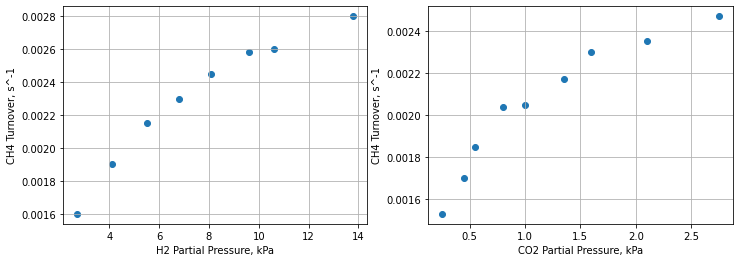

In [4]:
#Reproduction (estimate) of Fig. 1 and 2 from the paper
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(12,4))
#fig.suptitle('Horizontally stacked subplots')
ax1.scatter(H2P_1,CH4TON_1)
ax2.scatter(CO2P_2,CH4TON_2)
ax1.set(xlabel='H2 Partial Pressure, kPa')
ax1.set(ylabel='CH4 Turnover, s^-1')
ax2.set(xlabel='CO2 Partial Pressure, kPa')
ax2.set(ylabel='CH4 Turnover, s^-1')
ax1.grid()
ax2.grid()
plt.show()

### Turnover to Reaction Rate

In [5]:
ninB = flowratesccmB/(60*1e6)*(101325)/(Rg*(298)) #moles per second

In [6]:
flowratesccmB

500.0

In [7]:
rateB_1 = CH4TON_1*sitesperkg #molCH4/kg/s
rateB_2 = CH4TON_2*sitesperkg #molCH4/kg/s

In [8]:
dd = {'rate(mol/kg/s)':np.append(rateB_1,rateB_2),'P_H2(kPa)':np.append(H2P_1,np.ones(9)*5.6),
      'P_CO2(kPa)':np.append(np.ones(8)*1.4,CO2P_2),'T(K)':np.ones(17)*525,'Ptot(kPa)':np.ones(17)*140,
      'source':['data']*17}

In [9]:
df1 = pd.DataFrame(dd)

In [10]:
df1['predicted']=1.56e5*np.exp(-89000/Rg/df1['T(K)'])*df1['P_H2(kPa)']**0.35*df1['P_CO2(kPa)']**0.2
df1['SE']=(df1['predicted']-df1['rate(mol/kg/s)'])**2

In [11]:
df2 = df1.copy()
df2['source'] = 'power'
df2['rate(mol/kg/s)']=df1['predicted']
df=pd.concat([df1,df2])

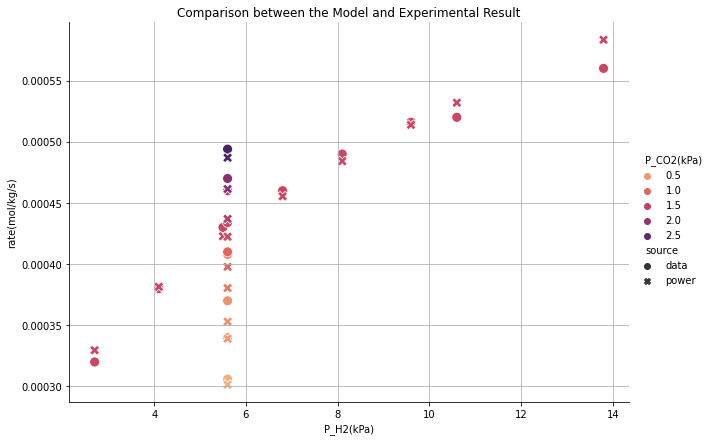

In [12]:
a = sns.relplot(data=df,x='P_H2(kPa)',y='rate(mol/kg/s)',hue='P_CO2(kPa)',
                s=100,style='source', palette='flare',aspect=12/8,height=6)
#a.axes[0,0].set_ylim(0,40); 
a.set(title='Comparison between the Model and Experimental Result')
plt.grid()
plt.show()

The above plot shows some of the data from the paper (circles) versus the power law model estimated from the paper. The equation is:<br>
$r = A\cdot e^{-Ea/(R\cdot T)}\cdot P_{H2}^{m}\cdot P_{CO2}^{n}$<br> with parameter values of:
<table>
        <tr>
        <td>A</td><td>Ea, kJ/mol</td><td>m (H2)</td><td>n (CO2)</td>
            </tr>
    <tr>
        <td>1.56E5</td><td>89</td><td>0.35</td><td>0.2</td>
    </tr>
</table>
The resulting rate is moles of methane produced per kilogram of catalyst per second. The pressures are in units of kPa (gauge).